# NLP (Natural Language Processing)

Via the site 'Beingdatum.com' I've followed the course: 'Guide on Deep Learning for NLP'.

This Notebook is a summary of that course, which I will use as reference work when having questions in a NLP project.

## Text Classification

In this lesson, we will focus on text classification.

- Example: Sentiment Analysis
- Input: text of reviews
- Output: Class of sentiments i.e. positive or negative

Positive example: The hotel is really beautiful, it was a nice stay at the hotel.

Negative example: WiFi wasn’t working, lights went off during the night hours, it was an awful experience staying at this hotel.

In [ ]:
import pandas as pd
import gzip
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer



In [10]:
def ingest_train():
    data = pd.read_csv('dataset.csv', encoding="ISO-8859-1")
    data = data[data.Sentiment.isnull() == False]
    data = data[data.Sentiment.isnull() == False]
    data['Sentiment'] = data['Sentiment'].map(int)
    data = data[data['SentimentText'].isnull() == False]
    data.reset_index(inplace=True)
    data.drop('index', axis=1, inplace=True)
    return data

train = ingest_train()
train.head()

,SentimentText,Sentiment
0,"first think another Disney movie, might good, ...",1
1,"Put aside Dr. House repeat missed, Desperate H...",0
2,"big fan Stephen King's work, film made even gr...",1
3,watched horrid thing TV. Needless say one movi...,0
4,truly enjoyed film. acting terrific plot. Jeff...,1


### 1. Data Preparation

Let’s do some data cleaning.

Let’s first define the data cleaning function, then apply it to the whole dataset. This function removes URL, remove HTML tags, handle negation words which are split into two parts, convert the words to lower cases, remove all non-letter characters. These elements are very common and they do not provide enough semantic information for the task.

In [11]:
import re

pat_1 = r"(?:\@|https?\://)\S+"
pat_2 = r'#\w+ ?'
combined_pat = r'|'.join((pat_1, pat_2))
www_pat = r'www.[^ ]+'
html_tag = r'<[^>]+>'
negations_ = {"isn't":"is not", "can't":"can not","couldn't":"could not", "hasn't":"has not",
"hadn't":"had not","won't":"will not",
"wouldn't":"would not","aren't":"are not",
"haven't":"have not", "doesn't":"does not","didn't":"did not",
"don't":"do not","shouldn't":"should not","wasn't":"was not", "weren't":"were not",
"mightn't":"might not",
"mustn't":"must not"}
negation_pattern = re.compile(r'\b(' + '|'.join(negations_.keys()) + r')\b')

from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()

def data_cleaner(text):
    try:
        stripped = re.sub(combined_pat, '', text)
        stripped = re.sub(www_pat, '', stripped)
        cleantags = re.sub(html_tag, '', stripped)
        lower_case = cleantags.lower()
        neg_handled = negation_pattern.sub(lambda x: negations_[x.group()], lower_case)
        letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
        tokens = tokenizer.tokenize(letters_only)
        return (" ".join(tokens)).strip()
    except:
        return 'NC'
#The results of this should give us a cleaned dataset and remove lines with ‘NC’.

In [12]:
#Next, let’s define a handy function to monitor DataFrame creations, then look at our cleaned data.
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

def post_process(data, n=1000000):
    data = data.head(n)
    data['SentimentText'] = data['SentimentText'].progress_map(data_cleaner) 
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    return data

train = post_process(train)

progress-bar: 100%|████████████████████████████████████████████████████████████| 25000/25000 [00:04<00:00, 5813.23it/s]


In [13]:
#Let’s save the cleaned data:

clean_data = pd.DataFrame(train,columns=['SentimentText'])
clean_data['Sentiment'] = train.Sentiment

clean_data.to_csv('clean_data.csv',encoding='utf-8')

csv = 'clean_data.csv'
data = pd.read_csv(csv,index_col=0)
data.head()

,SentimentText,Sentiment
0,first think another disney movie might good it...,1
1,put aside dr house repeat missed desperate hou...,0
2,big fan stephen king s work film made even gre...,1
3,watched horrid thing tv needless say one movie...,0
4,truly enjoyed film acting terrific plot jeff c...,1


### 2. Data visualization

Before proceeding to the classification step, let’s do some visualization of our textual data. the words cloud is the best choice for this matter, it is a visual representation of text data. It displays a list of words, the importance of each being shown with font size or color. This format is useful for quickly perceiving the most prominent terms.

For this data viz, we use the python library wordcloud.

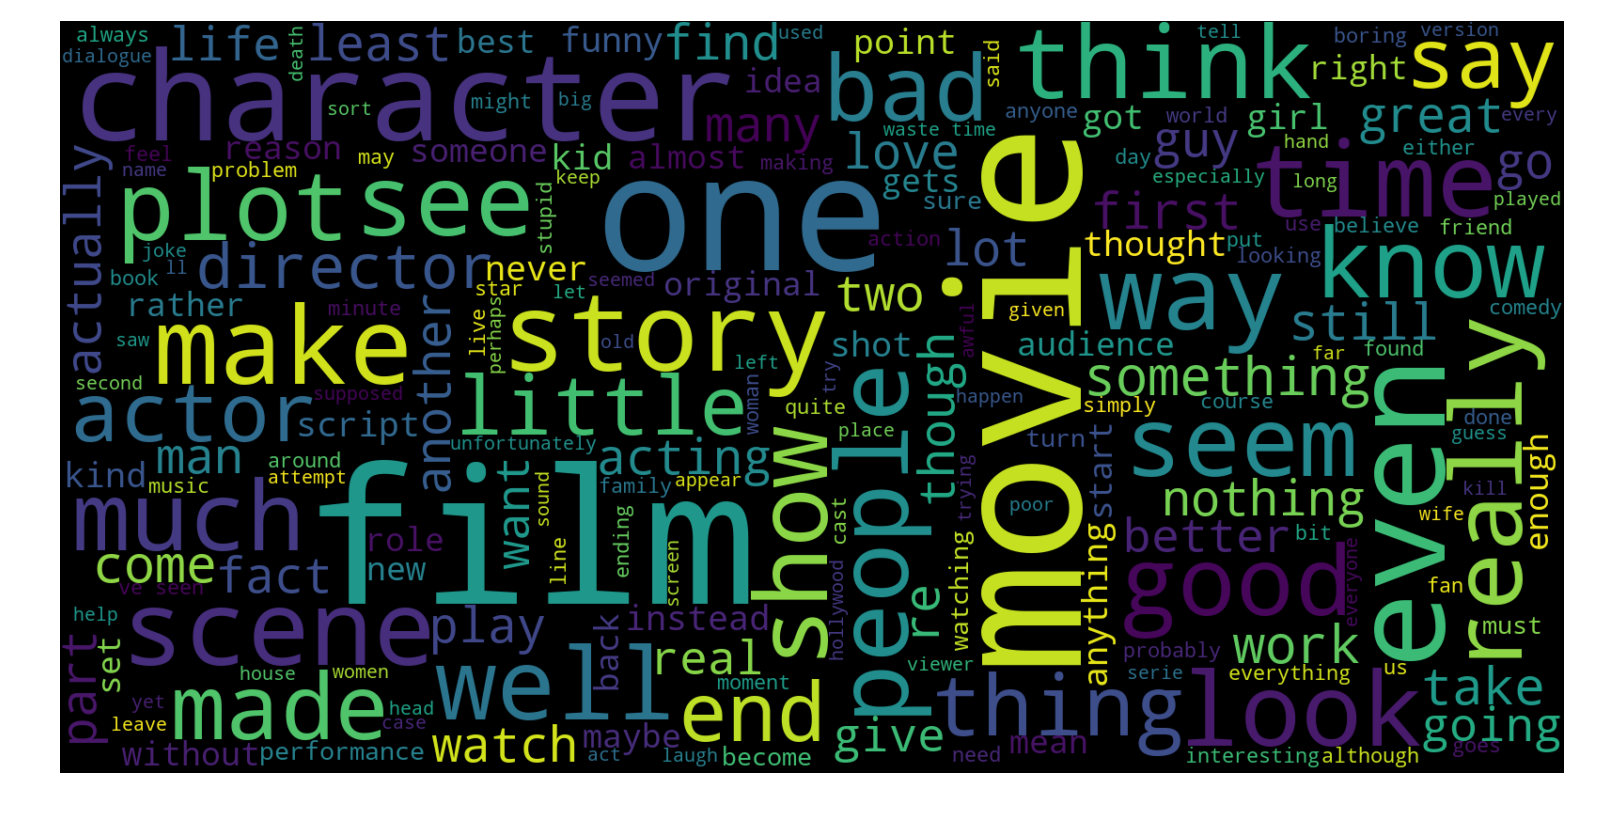

In [18]:
#Let’s begin with the word cloud of negative terms.
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from wordcloud import WordCloud, STOPWORDS


neg_tweets = train[train.Sentiment == 0]
neg_string = []

for t in neg_tweets.SentimentText:
    neg_string.append(t)

neg_string = pd.Series(neg_string).str.cat(sep=' ')

from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

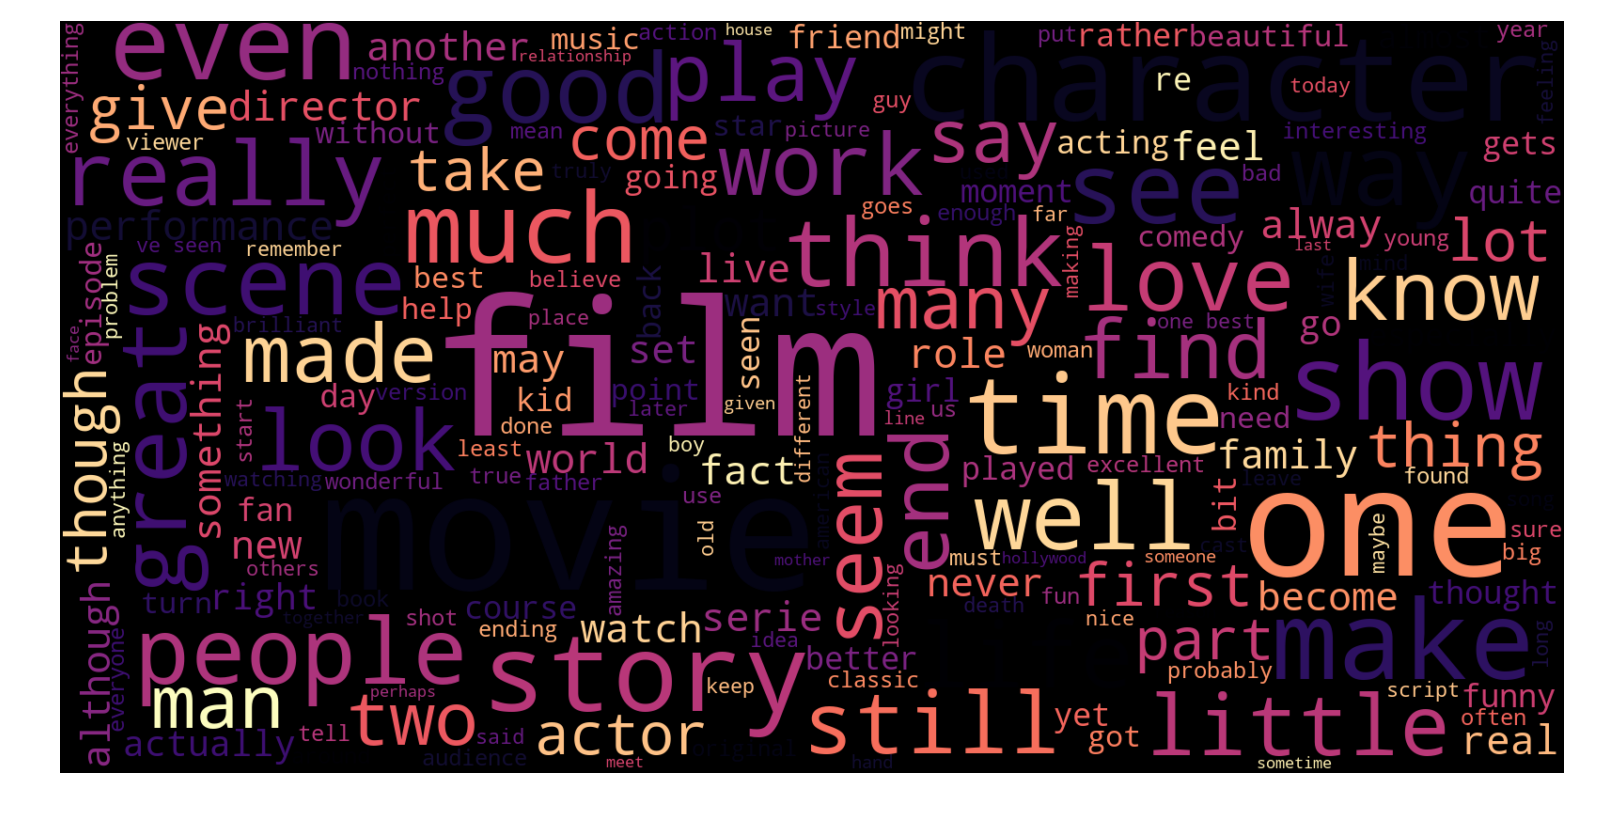

In [19]:
#The world cloud for the positive terms
pos_tweets = train[train.Sentiment == 1]
pos_string = []
for t in pos_tweets.SentimentText:
    pos_string.append(t)

pos_string = pd.Series(pos_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

### 3. Building the models

Before proceeding to the training phases, let’s split our data into training and validation set.

In [21]:
#Spliting The Data
from sklearn.model_selection import train_test_split 
SEED = 2000

x_train, x_validation, y_train, y_validation = train_test_split(train.SentimentText, train.Sentiment, test_size=.2, random_state=SEED)

### 4. Features Extraction

In this part, we will use a feature extraction technique called Tfidf vectorizer of 100,000 features including up to trigram. This technique is a way to convert textual data to the numeric form.

The below model_comparator function, we will use a custom function acc_summary, which reports validation accuracy, and the time it took to train and evaluate.

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
import numpy as np
from time import time


def acc_summary(pipeline, x_train, y_train, x_test, y_test):
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time


from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel

names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
        "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
        LogisticRegression(),
        LinearSVC(),
        Pipeline([
            ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
            ('classification', LinearSVC(penalty="l2"))]),
        MultinomialNB(),
        BernoulliNB(),
        RidgeClassifier(),
        AdaBoostClassifier(),
        Perceptron(),
        PassiveAggressiveClassifier(),
        NearestCentroid()
        ]
zipped_clf = zip(names,classifiers)

tvec = TfidfVectorizer()

def classifier_comparator(vectorizer=tvec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
                            ('vectorizer', vectorizer),
                            ('classifier', c)
                            ])
        print("Validation result for {}".format(n))
        print(c)
    clf_acc,tt_time = acc_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
    result.append((n,clf_acc,tt_time))
    return result

In [30]:
classifier_comparator(vectorizer=tvec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf)

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0),
        max_features=None, n...ax_iter=1000,
     multi_class='ovr', penalty='l2', 

[('Nearest Centroid', 0.7964, 3.6901793479919434)]